## Meta Learning on Sine Wave using Recurrence, MAML and Reptile 

In [1]:
import torch
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from meta import SineWaveTask, SineModel, maml, reptile
import matplotlib.pyplot as plt

In [2]:
# Training MAML model
training_size = 10000
testing_size = 1000
k = 10
N = 50
training_tasks = [SineWaveTask(k, N) for _ in range(training_size)]
testing_tasks = [SineWaveTask(k, N) for _ in range(testing_size)]

In [3]:
meta_model_maml, loss = maml(SineModel, training_tasks, loss_fn=F.mse_loss)

In [4]:
 meta_model_reptile, loss = reptile(SineModel, training_tasks, loss_fn=F.mse_loss)

In [6]:
def finetune_and_plot(meta_model, task, lr=0.02, fits=(0, 1, 20)):
    new_model = SineModel()
    new_model.copy(meta_model, same_var=False)
    optim = torch.optim.SGD(new_model.params(), lr=lr)
    
    test_loss_history = []
    test_y_hat_history = {}
    
    train_x, train_y = task.training_set()
    test_x, test_y = task.testing_set()
    
    for i in range(np.max(fits) + 1):
        # evaluate test loss and predict output
        with torch.no_grad():
            test_loss = F.mse_loss(new_model.forward(test_x), test_y).item()
            test_loss_history.append(test_loss)
            if i in fits:
                test_y_hat = new_model.forward(test_x)
                test_y_hat_history[i] = test_y_hat
        
        # adapt
        optim.zero_grad()
        loss = F.mse_loss(new_model.forward(train_x), train_y)
        loss.backward()
        optim.step()
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_x, train_y, '^', label='train')
    plt.plot(test_x, test_y, label='ground truth')
    for i, test_y_hat in test_y_hat_history.items():
        plt.plot(test_x, test_y_hat, label='after {} steps'.format(i))
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(test_loss_history)

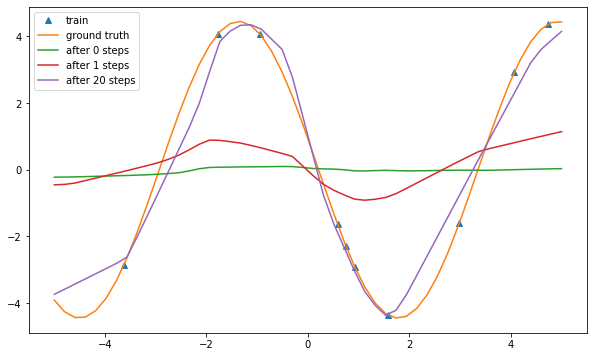

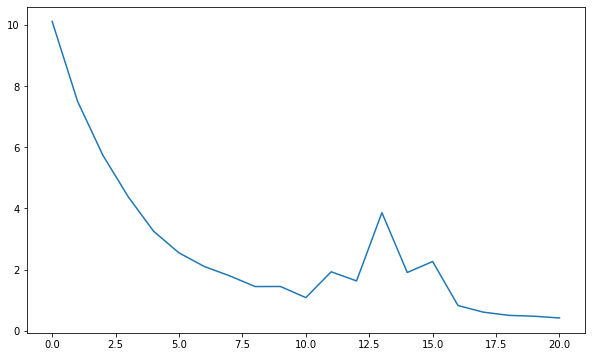

In [7]:
finetune_and_plot(meta_model_maml, testing_tasks[2])

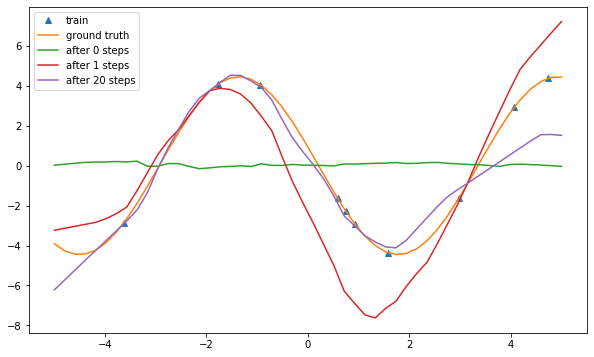

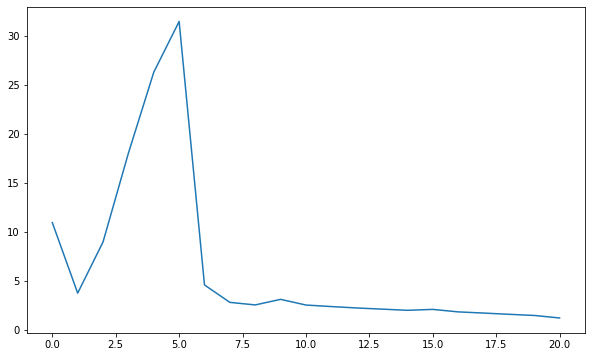

In [8]:
finetune_and_plot(meta_model_reptile, testing_tasks[2])